# Tarea 3: Evaluación de Segmentación


## 1. Importaciones y Configuración

In [49]:
# 1. Importaciones y Configuración
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import graph, segmentation, metrics
print("Todas las dependencias están correctamente instaladas")

Todas las dependencias están correctamente instaladas


## 2. Funciones de Carga y Visualización

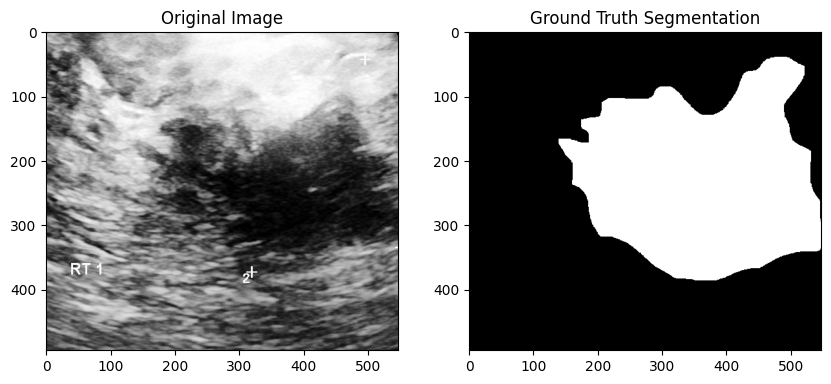

In [50]:


# Load the original image (to be segmented)
original_image = cv2.imread("../dataset/malignant/malignant (2).png", cv2.IMREAD_GRAYSCALE)

# Load the ground truth segmentation
ground_truth = cv2.imread("../dataset/malignant/malignant (2)_mask.png", cv2.IMREAD_GRAYSCALE)

# Normalize the original image for better contrast
original_image = cv2.equalizeHist(original_image)

# Display the images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(ground_truth, cmap='gray')
plt.title("Ground Truth Segmentation")

plt.show()


Define the Split and Merge Algorithm

In [51]:
def split(image, x, y, width, height, threshold):
    """ Recursively split an image using a quadtree approach based on variance. """
    if width < 2 or height < 2:  
        return [(x, y, width, height)]  # Stop splitting if region is too small

    region = image[y:y+height, x:x+width]
    mean, std = np.mean(region), np.std(region)  # Compute mean and standard deviation

    if std < threshold:  
        return [(x, y, width, height)]  # Stop if region is homogeneous

    # Split into four quadrants
    half_w, half_h = width // 2, height // 2
    regions = []
    regions += split(image, x, y, half_w, half_h, threshold)            # Top-left
    regions += split(image, x + half_w, y, half_w, half_h, threshold)    # Top-right
    regions += split(image, x, y + half_h, half_w, half_h, threshold)    # Bottom-left
    regions += split(image, x + half_w, y + half_h, half_w, half_h, threshold)  # Bottom-right

    return regions


Merge Similar Regions

In [52]:
def merge(image, regions, threshold):
    """ Merge similar regions using Region Adjacency Graph (RAG). """

    # Generate labels using SLIC (Superpixel Segmentation)
    labels = segmentation.slic(image, compactness=10, n_segments=len(regions), start_label=1, channel_axis=None)

    # Construct Region Adjacency Graph (RAG)
    rag = graph.rag_mean_color(image, labels)

    # ✅ Store 'mean color' as a float (not a dictionary or NumPy array)
    for node in rag.nodes:
        rag.nodes[node]['mean color'] = float(np.mean(image[labels == node]))

    # ✅ Define merging function without using .update()
    def merge_func(rag, src, dst):
        """ Merge function to correctly modify region attributes """
        src_mean = rag.nodes[src]['mean color']  # ✅ Correct float access
        dst_mean = rag.nodes[dst]['mean color']  # ✅ Correct float access

        # ✅ Directly assign the merged float value (no .update())
        rag.nodes[dst]['mean color'] = (src_mean + dst_mean) / 2  

    # ✅ Define weight function for merging
    def weight_func(rag, src, dst, n):
        return abs(rag.nodes[src]['mean color'] - rag.nodes[dst]['mean color'])

    # ✅ Perform hierarchical merging
    merged_labels = graph.merge_hierarchical(
        labels, rag, thresh=threshold, rag_copy=False,
        in_place_merge=True, merge_func=merge_func, weight_func=weight_func
    )

    return merged_labels  # ✅ Return the label map


Apply Split and Merge on the Image

In [53]:
# Set optimized thresholds
threshold_split = 15  # Lower values give finer splits
threshold_merge = 10  # Controls similarity for merging

# Perform Split
regions = split(original_image, 0, 0, original_image.shape[1], original_image.shape[0], threshold_split)

# Perform Merge
segmented_image = merge(original_image, regions, threshold_merge)

# Display results
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")

# Ground Truth
plt.subplot(1, 3, 2)
plt.imshow(ground_truth, cmap='gray')
plt.title("Ground Truth Segmentation")

# Segmented image
plt.subplot(1, 3, 3)
plt.imshow(segmented_image, cmap='gray')
plt.title("Segmented Image")

plt.show()


AttributeError: 'float' object has no attribute 'update'